## Globo Terraqueo

In [ ]:
!pip install Basemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 38.5 MB/s eta 0:00:00


## Datos: agregar los puntos

In [ ]:
import pandas as pd

# ----------------------------
# 1. Cargar datos
# ----------------------------
data_mig = pd.read_csv(
    "datosglobo_inm.csv",
    sep=';',           # separador de columnas
    thousands='.',     # puntos son miles
    decimal=','        # coma como decimal (si tu CSV tiene comas decimales)
)

# ----------------------------
# 2. Filtrar año 2021 y top 10 países por valor
# ----------------------------
# 2️⃣ Top 2 países por migración en 2021
top_paises = (
    data_mig
    .groupby('pais', as_index=False)['valor']  # Agrupamos por país
    .sum()                                     # Sumamos todos los años
    .nlargest(10, 'valor')                     # Tomamos los 2 con mayor suma
)

# 3️⃣ Filtrar datos originales solo para esos países
studio = data_mig[data_mig['pais'].isin(top_paises['pais'].tolist())]



print("Países seleccionados (top 2 en 2021) con primeros 5 registros:")
print(studio['pais'].unique())
studio.head()
print(len(studio))

studio.head()

Países seleccionados (top 2 en 2021) con primeros 5 registros:
['Argentina' 'Colombia' 'Honduras' 'Italia' 'Marruecos' 'Perú' 'Rumanía'
 'Reino Unido' 'Ucrania' 'Venezuela']
30


,long,lat,group,order,region,subregion,año,pais,valor
0,-64.549164,-54.716213,17,1148,Argentina,Isla de los Estados,2023,Argentina,34951
1,-64.549164,-54.716213,17,1148,Argentina,Isla de los Estados,2022,Argentina,33823
2,-64.549164,-54.716213,17,1148,Argentina,Isla de los Estados,2021,Argentina,20714
21,-78.113716,2.541748,437,32966,Colombia,1,2023,Colombia,170489
22,-78.113716,2.541748,437,32966,Colombia,1,2022,Colombia,171982


# Video+Grafico



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from geopy.distance import geodesic
from matplotlib.animation import FFMpegWriter
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
# ============================
# 1️⃣ Datos
# ============================
data = studio  # DataFrame con columnas: region, año, valor, lat, long, pais

lat_end, lon_end = 40.0, -4.0  # España

ultimos_años = sorted(data['año'].unique())

# Lista de países únicos
paises_unicos = data['pais'].unique()

# Calcular totales acumulados
totales_3años = {}
for pais in paises_unicos:
    df_pais = data[(data['pais']==pais) & (data['año'].isin(ultimos_años))]
    totales_3años[pais] = df_pais['valor'].sum()

# Ordenar países por total acumulado ascendente
paises = sorted(totales_3años, key=lambda x: totales_3años[x])


# ============================
# 2️⃣ Preparar trayectorias y transición
# ============================
trayectorias, años_totales, valores_totales, paises_totales = [], [], [], []

for pais in paises:
    df_pais = data[data['pais']==pais].sort_values('año')
    lat_start, lon_start = df_pais['lat'].iloc[0], df_pais['long'].iloc[0]

    dist_total = geodesic((lat_start, lon_start), (lat_end, lon_end)).km
    n_steps = max(20, int(dist_total / 300))

    lats = np.linspace(lat_start, lat_end, n_steps)
    lons = np.linspace(lon_start, lon_end, n_steps)

    cortes = np.linspace(0, n_steps, len(df_pais)+1, dtype=int)
    años = []
    valores = []

    for i, año in enumerate(df_pais['año']):
        n_rep = cortes[i+1] - cortes[i]
        años.extend([año]*n_rep)
        valores.extend([df_pais['valor'].iloc[i]]*n_rep)

    for i in range(n_steps):
        trayectorias.append((lats[i], lons[i]))
        años_totales.append(años[i])
        valores_totales.append(valores[i])
        paises_totales.append(pais)

# ============================
# 3️⃣ Preparar diccionario por país
# ============================
lineas = {pais: {'años': [], 'valores': []} for pais in paises}
for pais in paises:
    df_pais = data[data['pais']==pais].sort_values('año')
    lineas[pais]['años'] = df_pais['año'].tolist()
    lineas[pais]['valores'] = df_pais['valor'].tolist()

colores = plt.cm.tab20(np.linspace(0,1,len(paises)))
color_dict = {pais: col for pais, col in zip(paises, colores)}
all_years = sorted(data['año'].unique())

# ============================
# 4️⃣ Crear figura
# ============================
# Figura más compacta
fig = plt.figure(figsize=(10,8))  # antes era (10,12)
gs = gridspec.GridSpec(3,1,height_ratios=[2,0.05,1], figure=fig)

# Fondo
fondo = mpimg.imread("8729.jpg")
ax0 = fig.add_axes([0,0,1,1])
ax0.imshow(fondo, extent=[0,1,0,1], transform=ax0.transAxes)
ax0.axis('off')

# Panel mapa
ax1 = fig.add_axes([0, 0.3, 1, 0.65], facecolor='black')
ax1.set_axis_off()

# Panel gráfico inferior
ax2 = fig.add_axes([0,0.02,1,0.25], facecolor='black')  # altura más pequeña

# Firma y título
fig.text(0.99, 0.97, "Alejandra Venegas", color='white',
         fontsize=10, ha='right', va='top', alpha=0.6)  # esquina superior derecha
fig.text(0.5, 0.97, "Migración a España: evolución por nacionalidad",
         color='white', fontsize=15, fontweight='bold', ha='center', va='top')


# ============================
# 5️⃣ Función de actualización
# ============================
# Diccionario para mantener valores fijos una vez que un país aparece
valores_fijos = {pais: 0 for pais in paises}

def update(frame):
    lat, lon = trayectorias[frame]
    año_actual = int(años_totales[frame])
    valor_actual = valores_totales[frame]
    pais_actual = paises_totales[frame]

    # ---- Mapa ----
    ax1.clear()
    ax1.set_axis_off()
    m_new = Basemap(projection='ortho', lat_0=lat, lon_0=lon, resolution='c', ax=ax1)
    m_new.bluemarble(scale=0.5)
    m_new.drawcoastlines(color='white', linewidth=0.8)

    x, y = m_new(lon, lat)
    ax1.plot(x, y, 'o', color='red', markersize=8, markeredgecolor='white', markeredgewidth=0.5)
    ax1.text(x, y+4e5, f"{int(valor_actual):,}".replace(",", "."), color='white', fontsize=12,
             ha='center', fontweight='bold')
    ax1.text(x, y-4e5, pais_actual, color='white', fontsize=11, ha='center',
             bbox=dict(facecolor='black', alpha=0.5, boxstyle="round,pad=0.2"))
    ax1.text(0,0.95,f"Año: {año_actual}", transform=ax1.transAxes,
             color='white', fontsize=14, fontweight='bold')

    # ---- Gráfico inferior: barras progresivas ----
    ax2.clear()
    ax2.set_facecolor('black')

    # Restaurar ejes
    for spine in ['bottom','left','top','right']:
        ax2.spines[spine].set_visible(True)
        ax2.spines[spine].set_color('white')
        ax2.spines[spine].set_linewidth(1.2)

    ax2.yaxis.set_tick_params(color='white', labelcolor='white')
    ax2.xaxis.set_tick_params(color='white', labelcolor='white')
    ax2.set_ylabel("Valor", color='white', fontsize=12)
    ax2.set_xlabel("País", color='white', fontsize=12)
    ax2.tick_params(axis='y', colors='white', labelsize=10)
    ax2.set_ylim(0, max(data['valor'].max(), max(totales_3años.values()))*1.2)
    ax2.grid(True, linestyle="--", alpha=0.3, color='gray')

    # Actualizar valor fijo del país actual
    if valores_fijos[pais_actual] == 0:
        # Al aparecer el país, asignamos su valor total
        valores_fijos[pais_actual] = totales_3años[pais_actual]

    # Preparar lista de valores para todas las barras
    valores_bar = [valores_fijos[p] for p in paises]

    # Dibujar barras con ancho reducido
    ax2.bar(range(len(paises)), valores_bar, color=[color_dict[p] for p in paises], width=0.6)

    # Etiquetas de país visibles
    ax2.set_xticks(range(len(paises)))
    ax2.set_xticklabels(paises, rotation=45, ha='right', fontsize=8, color='white')

    # Números encima de las barras
    for i, v in enumerate(valores_bar):
      if v > 0:
        altura_total = max(data['valor'].max(), max(totales_3años.values()))
        # Número total encima de la barra
        ax2.text(i, v + altura_total*0.01,
                 f"{int(v):,.0f}".replace(",", "."), color='white',
                 ha='center', fontweight='bold', fontsize=9)
        # Nombre del país arriba del número
        ax2.text(i, v + altura_total*0.08,
                 paises[i], color='white', ha='center', fontsize=7)



    ax2.set_title("Total acumulado de migrantes por nacionalidad (2023-2021)", fontsize=12, color='white')

    return ax1, ax2


# ============================
# 6️⃣ Guardar animación
# ============================
metadata = dict(title="Mapa + gráfico sincronizado", artist="Alejandra Venegas")
writer = FFMpegWriter(fps=8, metadata=metadata)

pais_inicial = paises[0]
df_ini = data[data['pais']==pais_inicial].sort_values('año')
lat_ini, lon_ini = df_ini['lat'].iloc[0], df_ini['long'].iloc[0]

n_frames_zoom = 15  # cantidad de frames del zoom inicial

with writer.saving(fig, "video_mapa_grafico_sincronizado.mp4", dpi=150):

    # ---- Zoom inicial ----
    lat_start_zoom = 0.0  # desde lejos
    lon_start_zoom = 0.0
    for f in range(n_frames_zoom):
        # Interpolación lineal del centro
        lat_c = lat_start_zoom + (lat_ini - lat_start_zoom)*(f+1)/n_frames_zoom
        lon_c = lon_start_zoom + (lon_ini - lon_start_zoom)*(f+1)/n_frames_zoom

        # Dibujar mapa con el país inicial marcado
        ax1.clear()
        ax1.set_axis_off()
        m = Basemap(projection='ortho', lat_0=lat_c, lon_0=lon_c, resolution='c', ax=ax1)
        m.bluemarble(scale=0.5)
        m.drawcoastlines(color='white', linewidth=0.8)
        # marcador del país inicial
        x, y = m(lon_ini, lat_ini)
        ax1.plot(x, y, 'o', color='red', markersize=8, markeredgecolor='white', markeredgewidth=0.5)
        ax1.text(x, y-4e5, pais_inicial, color='white', fontsize=11, ha='center',
                 bbox=dict(facecolor='black', alpha=0.5, boxstyle="round,pad=0.2"))
        writer.grab_frame()

    # ---- Animación normal ----
    for f in range(len(trayectorias)):
        update(f)
        writer.grab_frame()


plt.close()


# Imagen pagina web


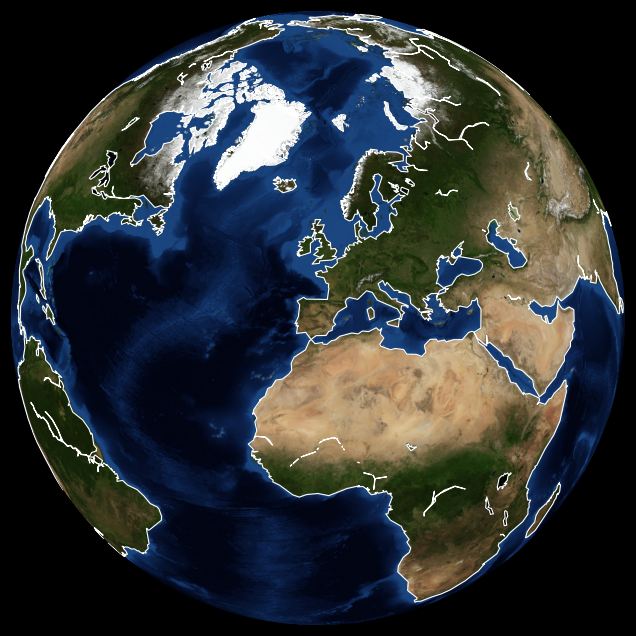

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Crear figura con fondo negro
fig = plt.figure(figsize=(10, 8), facecolor='black')
ax = fig.add_subplot(111, facecolor='black')

# Configurar proyección ortográfica centrada en España
m = Basemap(projection='ortho', lat_0=40.0, lon_0=-4.0, resolution='c', ax=ax)

# Dibujar el mundo
m.bluemarble(scale=0.5)  # textura del planeta
m.drawcoastlines(color='white', linewidth=0.8)  # costas en blanco

# Quitar ejes
ax.set_axis_off()

# Guardar como imagen
plt.savefig("mapa_mundo.png", dpi=300, bbox_inches='tight', facecolor='black')
plt.show()
